#Importing libaries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

#Functions

In [2]:
def show_image(image, title="title", cmap_type="gray"):
    plt.imshow(image, cmap_type)
    plt.title(title)

In [3]:
def get_src_dst(image):
    src = [[570,460],[image.shape[1] - 573,460],[image.shape[1] - 150,image.shape[0]],[150,image.shape[0]]]
    dst = [[200,0],[image.shape[1]-200,0],[image.shape[1]-200,image.shape[0]],[200,image.shape[0]]]
    
    return src, dst

In [4]:
def thresholding(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    sobel_kernel=3
    thresh=(5, 100)
    mag_thresh=(3, 255)
    dir_thresh=(45*np.pi/180, 75*np.pi/180) 
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobel_absx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_absy = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    
    scaled_sobel_absx = np.uint8(255 * sobel_absx / np.max(sobel_absx))
    sobel_binary = np.zeros_like(scaled_sobel_absx)
    sobel_binary[(scaled_sobel_absx > thresh[0]) & (scaled_sobel_absx <= thresh[1])] = 1
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_absx**2 + sobel_absy**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobel_absy), np.absolute(sobel_absx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    combined = np.zeros_like(dir_binary, np.uint8)    
    combined[(sobel_binary == 1) & ((mag_binary == 1) | (dir_binary == 1))] = 1
    
    # Threshold color channel
    s_thresh_min = 50
    s_thresh_max = 255
    l_thresh_min = 140
    l_thresh_max = 255  
    
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)) ] = 1
    l_binary = np.zeros_like(s_channel)
    l_binary[((l_channel >= l_thresh_min) & (l_channel <= l_thresh_max))] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[((s_binary == 1) & (combined == 1)) | ((combined == 1) & (l_binary == 1))] = 1
    
    return combined_binary, sobel_binary, combined

In [5]:
def warp(image, src, dst):

    src = np.float32([src])
    dst = np.float32([dst])
    
    return cv2.warpPerspective(image, cv2.getPerspectiveTransform(src, dst),
                               (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)

In [6]:
class LaneDetector:
    
    def __init__(self):
        self.detected = True
        self.left_lane_inds = []  # Create empty lists to receive left and right lane pixel indices
        self.right_lane_inds = []
        
        self.n_frames = 10
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = [np.zeros_like(720, np.float32), np.zeros_like(720, np.float32)]
        
        # coefficient values of the last n fits of the line
        self.recent_coefficients = []
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [0,0,0]
        
        self.vehicle_offset = 0.0
        self.avg_curverad = 1000

    def draw_lane(self, original_image, binary_warped, filtered_binary):
        
        # Allow image to be RGB to display sliding windows.
        image_with_windows = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
        
        nonzero = binary_warped.nonzero()  # Identify the x and y positions of all nonzero pixels in the image
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
         
        margin = 50   
        # Set minimum number of pixels found to recenter window   
        minpix = 50
        
        if self.detected:
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            nwindows = 9  # Choose the number of sliding windows
            window_height = np.int((binary_warped.shape[0])/nwindows)   # Set height of windows

            leftx_current = leftx_base   # Current positions to be updated for each window
            rightx_current = rightx_base   # Set the width of the windows +/- margin
            
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):

                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                  (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                   (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
                # Draw green rectangle at current windows.
                cv2.rectangle(image_with_windows, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
                cv2.rectangle(image_with_windows, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
                
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                    

            # Concatenate the arrays of indices
            self.left_lane_inds = np.concatenate(left_lane_inds)
            self.right_lane_inds = np.concatenate(right_lane_inds)
        else:
            self.left_lane_inds = ((nonzerox > (self.best_fit[0][0]*(nonzeroy**2) + self.best_fit[0][1]*nonzeroy + 
                                    self.best_fit[0][2] - margin)) & (nonzerox < (self.best_fit[0][0]*(nonzeroy**2) + 
                                    self.best_fit[0][1]*nonzeroy + self.best_fit[0][2] + margin))) 
            self.right_lane_inds = ((nonzerox > (self.best_fit[1][0]*(nonzeroy**2) + self.best_fit[1][1]*nonzeroy + 
                                    self.best_fit[1][2] - margin)) & (nonzerox < (self.best_fit[1][0]*(nonzeroy**2) + 
                                    self.best_fit[1][1]*nonzeroy + self.best_fit[1][2] + margin)))
        
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        # Fit a second order polynomial to each
        if lefty.shape[0] >= 400 and righty.shape[0] >= 400 and leftx.shape[0] >= 400 and rightx.shape[0] >= 400:
            self.detected = False
            self.left_fit = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
            
            
            if len(self.recent_coefficients) >= self.n_frames:
                self.recent_coefficients.pop(0)
            self.recent_coefficients.append([self.left_fit, self.right_fit])

            self.best_fit = [0,0,0]
            for coefficient in self.recent_coefficients:
                self.best_fit[0] = self.best_fit[0] + coefficient[0]
                self.best_fit[1] = self.best_fit[1] + coefficient[1]

            self.best_fit[0] = self.best_fit[0]/len(self.recent_coefficients)
            self.best_fit[1] = self.best_fit[1]/len(self.recent_coefficients)


            # Generate x and y values for plotting
            left_fitx = self.best_fit[0][0]*ploty**2 + self.best_fit[0][1]*ploty + self.best_fit[0][2]
            right_fitx = self.best_fit[1][0]*ploty**2 + self.best_fit[1][1]*ploty + self.best_fit[1][2]

            if len(self.recent_xfitted) >= self.n_frames:
                self.recent_xfitted.pop(0)


            self.recent_xfitted.append([left_fitx, right_fitx])


            self.bestx = [np.zeros_like(720, np.float32), np.zeros_like(720, np.float32)]
            for fit in self.recent_xfitted:
                self.bestx[0] = self.bestx[0] + fit[0]
                self.bestx[1] = self.bestx[1] + fit[1]

            self.bestx[0] = self.bestx[0]/len(self.recent_xfitted)
            self.bestx[1] = self.bestx[1]/len(self.recent_xfitted)
                     
            
        else:
            self.detected = True
        
        
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[self.right_lane_inds], nonzerox[self.right_lane_inds]] = [0, 0, 255]
        

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = 5
        left_line_window1 = np.array([np.transpose(np.vstack([self.bestx[0]-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.bestx[0]+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([self.bestx[1]-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.bestx[1]+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))


        center_line_window1 = np.array([np.transpose(np.vstack([self.bestx[0]+margin, ploty]))])
        center_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.bestx[1]-margin, ploty])))])
        center_line_pts = np.hstack((center_line_window1,center_line_window2))


        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,0, 0))
        cv2.fillPoly(window_img, np.int_([center_line_pts]), (0,255, 0))

        src, dst = get_src_dst(window_img)
        window_img_unwrapped = warp(window_img, dst, src)

        result = cv2.addWeighted(original_image, 1, window_img_unwrapped, 0.3, 0)
        
        return result, image_with_windows, window_img_unwrapped, self.left_fit, self.right_fit

In [7]:
def measure_curvature(image, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [8]:
def measure_position(image, left_fit, right_fit):
    # Define conversion in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Choose the y value corresponding to the bottom of the image
    y_max = image.shape[0]
    # Calculate left and right line positions at the bottom of the image
    left_x_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    # Calculate the x position of the center of the lane 
    center_lanes_x_pos = (left_x_pos + right_x_pos)//2
    # Calculate the deviation between the center of the lane and the center of the picture
    # The car is assumed to be placed in the center of the picture
    # If the deviation is negative, the car is on the felt hand side of the center of the lane
    veh_pos = ((image.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
    return veh_pos

In [9]:
def create_y_axis(image, left_fit, right_fit):
    # Create a y axis.
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    # Left line polynomial.
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    # Right Line polynomial.
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

In [10]:
def put_text(final_image , left_curverad , right_curverad , veh_pos):
    cv2.putText(final_image,'Curve Radius [m]: '+str((left_curverad+right_curverad)/2)[:7],(40,70), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6, (255,255,255),2,cv2.LINE_AA)
    cv2.putText(final_image,'Center Offset [m]: '+str(veh_pos)[:7],(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)
    return final_image

In [11]:
def combine_output(result, combined_binary, warped_image, image_with_windows, inv_warp, combined):
    combined_binary = cv2.cvtColor(combined_binary, cv2.COLOR_GRAY2RGB).astype(np.uint8)
    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_GRAY2RGB).astype(np.uint8)
    combined = cv2.cvtColor(combined, cv2.COLOR_GRAY2RGB).astype(np.uint8)
    image_with_windows = image_with_windows.astype(np.uint8)
    
    hor1 = np.concatenate((result, combined_binary, warped_image),axis=1)
    hor2 = np.concatenate((inv_warp, combined, image_with_windows),axis=1)
    final = np.concatenate((hor1, hor2),axis=0)
    final = cv2.resize(final, (0, 0), None, result.shape[1] / final.shape[1], result.shape[0] / final.shape[0])

    return final

Input

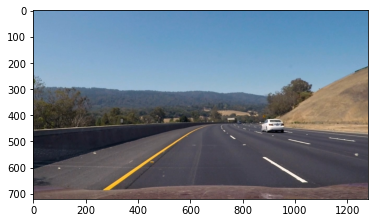

In [12]:
#Reading image
image = cv2.imread("./Project_data/test_images/test3.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Pipeline

In [17]:
lane_detector = LaneDetector()
draw_lane = lane_detector.draw_lane
def pipeline (image):
    #Applying Thresholding
    combined_binary, sobel_binary, combined = thresholding(image)
    
    #Getting src and dst
    src,dst = get_src_dst(image)
    
    #Applying perspective transform
    warped_image = warp(combined_binary, src, dst)
    
    #Sliding Window & Drawing Lane Lines Function
    final_image, image_with_windows, inv_warp, left_fit, right_fit = draw_lane(image, warped_image, combined_binary)
    
    #Calculating Curvature and position from center
    left_fitx, right_fitx, ploty = create_y_axis(image, left_fit, right_fit)
    left_curverad, right_curverad =  measure_curvature(warped_image, left_fitx, right_fitx, ploty)
    veh_pos = measure_position(warped_image, left_fit, right_fit)
    out_img = put_text(final_image , left_curverad , right_curverad , veh_pos)
        
    #Combining images to display
    result_final = combine_output(out_img, combined_binary*255, warped_image*255, image_with_windows, inv_warp, combined*255)
    
    #Final Output
    return result_final
    #return out_img

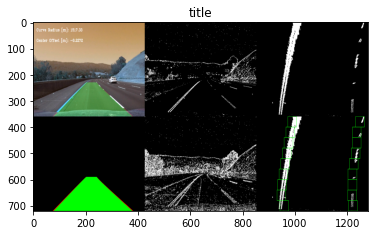

In [18]:
#Testing Pipeline and displaying output
final_image = pipeline(image)
show_image(final_image)

In [15]:
# Saving Output Video
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('./project_data/project_video.mp4')
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(video_output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 6min 6s


In [16]:
# Saving Output Video
video_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip('./project_data/challenge_video.mp4')
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(video_output, audio=False)

t:   0%|                                                                             | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
Wall time: 2min 30s


In [23]:
#Displaying video
cap = cv2.VideoCapture('./Project_data/project_video.mp4')

while cap.isOpened():
    ret, i = cap.read()

    if i is None:
        break
    cv2.imshow('frame', pipeline(i))

    # img_array.append(img)

    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()